# Implementar o Conditional GAN

- Usar Conditional GAN: [Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784) com o dataset criado a partir de um grafo causal implícito

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_num = pd.read_csv('../data/shap_dataset_example_50k_samples.csv')

In [3]:
df_num = df_num.rename(columns={"Delivery_price_proportion":"Free_shipment"})

In [4]:
for i in range(df_num.shape[0]):
    if df_num['Free_shipment'].iloc[i] <0.3:
        df_num['Free_shipment'].iloc[i] = -1
    elif df_num['Free_shipment'].iloc[i] >=0.3:
        df_num['Free_shipment'].iloc[i] = 0

In [5]:
df_num['Free_shipment'] = df_num['Free_shipment'].replace(-1,1)
df_num['Click_probability'] = np.round(df_num['Click_probability'],2)
df_num['Image_quality'] = np.round(df_num['Image_quality'],0)
df_num['Product_price'] = np.round(df_num['Product_price'],2)

In [7]:
df_num.to_csv('shap_dataset_50k_modified.csv',index=False)

In [8]:
df_num[df_num["Free_shipment"]==1].shape[0]/df_num.shape[0]

0.26368

In [9]:
df_num.head()

,Image_quality,Number_of_images,Product_price,Seller_latitude,Seller_longitude,Free_shipment,Click_probability
0,4.0,6.0,21.41,0.2,-0.3,0.0,0.44
1,4.0,6.0,15.78,1.9,-0.5,0.0,0.40
2,6.0,4.0,16.11,2.2,2.6,1.0,0.47
3,6.0,5.0,18.84,1.3,5.2,1.0,0.60
4,5.0,5.0,24.17,-0.7,0.3,0.0,0.43


---
### Funções de auxílio

In [10]:
def plot_losses(losses_his):
    plt.figure(figsize=(20,8))
    plt.subplot(221)
    plt.plot(losses_his[0])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Gerador')
    plt.subplot(222)
    plt.plot(losses_his[1])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: Discriminador')
    plt.subplot(223)
    plt.plot(losses_his[2])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D real')
    plt.subplot(224)
    plt.plot(losses_his[3])
    plt.grid(True)
    plt.xlabel('Epochs')
    plt.ylabel('Loss: D fake')
#     plt.savefig('images/losses_plot',quality=100)
    plt.show()

def gan_summary(df_num,rho):
    oh = np.eye(2)
    batch = X_tc.shape[0]
    l_s = np.random.choice([0,1],p=[1-rho,rho],size=(batch))
    l_s_ = torch.Tensor(oh[l_s]).type(torch.FloatTensor).cuda()
    l_s = torch.Tensor(l_s).type(torch.FloatTensor).reshape(batch,1).cuda()

    z = noise(batch, Z_dim).cuda()
    w = noise_uniform(batch, W_dim).cuda()
    g = G(z,w,l_s_)
    g = torch.Tensor(scaler.inverse_transform(g.cpu().data.numpy())).type(torch.FloatTensor).cuda()
    x_gen = torch.cat((g[:,0:5],l_s,g[:,5:]),dim=1)

    df_g = pd.DataFrame(data=x_gen.cpu().data.numpy(),columns=df_num.columns)

    df_g['Click_probability'] = np.round(df_g['Click_probability'].values,2)
    df_g['Image_quality'] = np.round(df_g['Image_quality'].values,0)
    df_g['Number_of_images'] = np.round(df_g['Number_of_images'].values,0)
    df_g['Product_price'] = np.round(df_g['Product_price'].values,2)
    
    df_g['Expected_income'] = df_g['Product_price'] * df_g['Click_probability']
    df_num['Expected_income'] = df_num['Product_price'] * df_num['Click_probability']

    #dataset fake
    print("Fake total expected income: {:.2f}\n".format(df_g['Expected_income'].sum()),df_g[['Product_price','Click_probability','Expected_income']].describe().loc[['mean','std','25%','50%','75%']])

    #dataset real
    print("Real total expected income: {:.2f}\n".format(df_num['Expected_income'].sum()),df_num.describe()[['Product_price','Click_probability','Expected_income']].loc[['mean','std','25%','50%','75%']])

    for col in ['Product_price','Click_probability','Expected_income']:
        plt.figure(figsize=(10,3))
        sns.distplot(df_num[col],label='Real')
        sns.distplot(df_g[col],label='Fake')
        plt.legend(loc=0)
        plt.grid(True)
        plt.show()
    
    df_g.drop('Expected_income',axis=1,inplace=True)
    df_num.drop('Expected_income',axis=1,inplace=True)

def noise(dim0,dim1):
    return Variable(Normal(loc=0, scale=5).sample(sample_shape=torch.Size([dim0,dim1])))

def noise_uniform(dim0,dim1):
    return Variable(Uniform(-5,5).sample(sample_shape=torch.Size([dim0,dim1])))

---

## ConditionalGAN

- Label: usaremos apenas um label, `bigode`.
- Gerador: receberá o ruído `z` e a label `y` e retornará o dado `G(z,y)`.
- Discriminador: receberá `G(z,y)` e `z` e retornará a probabilidade do dado ser real.

In [11]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch import optim
from torch.autograd import Variable
from torch import nn
from torch.distributions import Uniform
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [12]:
# probabilidade de ocorre bigode=1 no dataset
rho = df_num[df_num["Free_shipment"]==1].shape[0]/df_num.shape[0]
rho

0.26368

In [13]:
X_data = df_num.drop("Free_shipment",axis=1).copy().values
scaler.fit(X_data)
X_data = scaler.transform(X_data)
y_data = pd.get_dummies(df_num["Free_shipment"]).values.reshape(X_data.shape[0],2)
X_tc = torch.Tensor(X_data).type(torch.FloatTensor)
y_tc = torch.Tensor(y_data).type(torch.FloatTensor)
print(X_tc.shape, X_tc.type(),y_tc.shape, y_tc.type())

torch.Size([50000, 6]) torch.FloatTensor torch.Size([50000, 2]) torch.FloatTensor


In [14]:
Z_dim,W_dim,h_dim,X_dim,y_dim = [50,50,60,X_tc.shape[1],y_tc.shape[1]]

# Arquitetura do Gerador
class GNet(torch.nn.Module):
    def __init__(self):
        super(GNet,self).__init__()
        self.hidden = torch.nn.Linear(Z_dim+W_dim+y_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, X_dim)
    
    def forward(self,z,w,l):
        h = F.relu(self.hidden(torch.cat((z,w,l),dim=1)))
        h = nn.Dropout(p=0.25)(h)
        X = torch.sigmoid(self.out(h))
        return X

# Arquitetura do Discriminador
class DNet(torch.nn.Module):
    def __init__(self):
        super(DNet,self).__init__()
        self.hidden = torch.nn.Linear(X_dim+y_dim, h_dim)
        self.out = torch.nn.Linear(h_dim, 1)
    
    def forward(self,X,l):
        h = F.relu(self.hidden(torch.cat((X,l),dim=1)))
        h = nn.Dropout(p=0.7)(h)
        y = torch.sigmoid(self.out(h))
        return y

In [15]:
# Instanciamos as redes
G = GNet().cuda()
D = DNet().cuda()

# Definimos os otimizadores
lrg,lrd = [1e-4,1e-4]
G_optim = optim.Adam(G.parameters(),lr=lrg,betas=(0.9, 0.999),eps=1e-08,weight_decay=lrg*0.,amsgrad=False)
D_optim = optim.Adam(D.parameters(),lr=lrd,betas=(0.9, 0.999),eps=1e-08,weight_decay=lrd*0.,amsgrad=False)

def reset_grad():
    G_optim.zero_grad()
    D_optim.zero_grad()
    
batch = X_tc.shape[0]
ones  = Variable(torch.ones(batch, 1)).cuda()
zeros = Variable(torch.zeros(batch, 1)).cuda()
D_loss_real_func = nn.BCELoss()  
D_loss_fake_func = nn.BCELoss()
G_loss_func = nn.BCELoss()

def nets_test(n_sample,G,D):
    z = noise(n_sample, Z_dim).cuda()
    w = noise_uniform(n_sample,W_dim).cuda()
    x = torch.Tensor(X_tc[:n_sample]).cuda()
    l = torch.Tensor(y_tc[:n_sample]).cuda()
    g = G(z,w,l)
    D_real = D(x,l)
    D_fake = D(g,l)
    print('Average D_real  {:.6f}| Std D_real  {:.6f}'.format(D_real.mean(),D_real.std()))
    print('Average D_fake  {:.6f}| Std D_fake  {:.6f}'.format(D_fake.mean(),D_fake.std()))
    
G_his, D_his, D_real_his, D_fake_his = [[],[],[],[]]
losses_his = [G_his,D_his,D_real_his,D_fake_his] 

In [16]:
#load saved networks
# G.load_state_dict(torch.load('models/g_cond_gan_shap_50k_10k.pt'))
# D.load_state_dict(torch.load('models/d_cond_gan_shap_50k_10k.pt'))

In [17]:
%%time
epochs = 4000

for epoch in range(epochs):
    # Amostragem de dados
    z = noise(batch, Z_dim).cuda()
    w = noise_uniform(batch,W_dim).cuda()
    X = X_tc.cuda()
    l = y_tc.cuda()
    # Dicriminador
    G_sample = G(z,w,l)
    D_real = D(X,l)
    D_fake = D(G_sample,l)
    D_loss_real = D_loss_real_func(D_real, ones)
    D_loss_fake = D_loss_fake_func(D_fake, zeros)
    D_loss = D_loss_real + D_loss_fake
    D_loss.backward()
    D_optim.step()
    reset_grad()
    # Generador
    z = noise(batch, Z_dim).cuda()
    w = noise_uniform(batch,W_dim).cuda()
    G_sample = G(z,w,l)
    D_fake = D(G_sample,l)
    G_loss = G_loss_func(D_fake, ones)
    G_loss.backward()
    G_optim.step()
    reset_grad()
    # Recolher dados das funções de perda
    G_his.append(G_loss.data)
    D_his.append(D_loss.data)
    D_fake_his.append(D_loss_fake.data)
    D_real_his.append(D_loss_real.data)
    # Mostrar dados ao longo das epochs
    if epoch % int(epochs/6) == 0 and epoch > 0:
        print('Epoch-{}| Average D_loss: {:.5f}| Average G_loss: {:.5f}| Average D_real: {:.5f} | Average D_fake: {:.5f}'.format(
            epoch, D_loss.data, G_loss.data, D_loss_real.data, D_loss_fake.data))
        nets_test(30000,G,D)

Epoch-666| Average D_loss: 1.38286| Average G_loss: 0.70428| Average D_real: 0.69507 | Average D_fake: 0.68780
Average D_real  0.500013| Std D_real  0.035863
Average D_fake  0.495927| Std D_fake  0.037270
Epoch-1332| Average D_loss: 1.37785| Average G_loss: 0.72279| Average D_real: 0.71048 | Average D_fake: 0.66737
Average D_real  0.492164| Std D_real  0.025655
Average D_fake  0.485851| Std D_fake  0.027279
Epoch-1998| Average D_loss: 1.38296| Average G_loss: 0.70564| Average D_real: 0.70076 | Average D_fake: 0.68220
Average D_real  0.496720| Std D_real  0.021462
Average D_fake  0.494356| Std D_fake  0.019874
Epoch-2664| Average D_loss: 1.38830| Average G_loss: 0.68539| Average D_real: 0.68684 | Average D_fake: 0.70147
Average D_real  0.503369| Std D_real  0.012573
Average D_fake  0.504013| Std D_fake  0.013246
Epoch-3330| Average D_loss: 1.38603| Average G_loss: 0.69048| Average D_real: 0.68942 | Average D_fake: 0.69661
Average D_real  0.501879| Std D_real  0.009797
Average D_fake  0.

In [18]:
nets_test(50000,G,D)

Average D_real  0.495113| Std D_real  0.009006
Average D_fake  0.493664| Std D_fake  0.009391


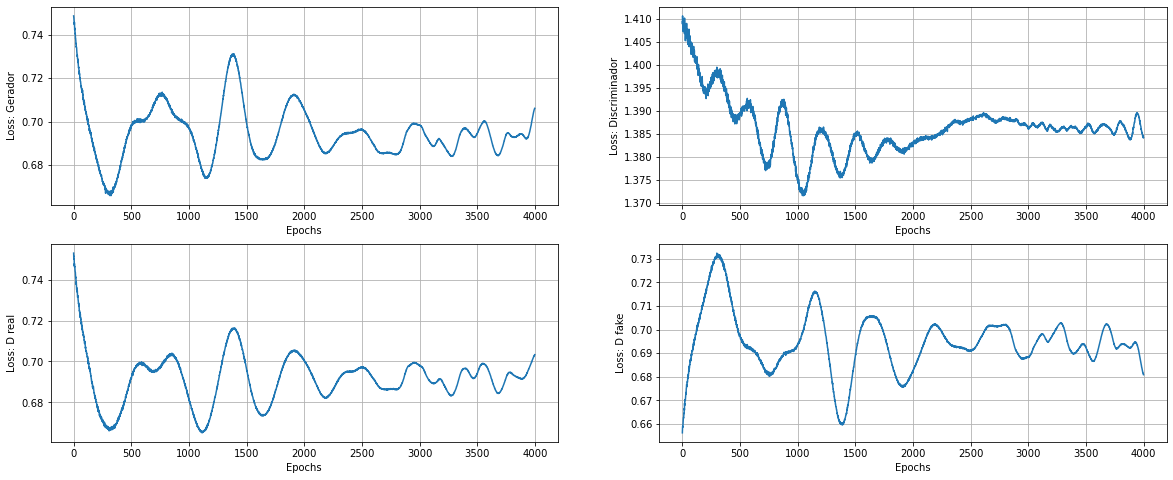

In [19]:
plot_losses(losses_his)

In [18]:
#save networks
# torch.save(G.state_dict(), 'models/g_cond_gan_shap_50k_10k.pt')
# torch.save(D.state_dict(), 'models/d_cond_gan_shap_50k_10k.pt')

## Reproduzindo mais dados como os do dataset inicial

In [20]:
rho

0.26368

Fake total expected income: 482477.06
       Product_price  Click_probability  Expected_income
mean      20.003603           0.480420         9.649496
std        5.706499           0.093092         3.710506
25%       15.480000           0.410000         7.133400
50%       18.920000           0.470000         8.569800
75%       23.370001           0.550000        11.054400
Real total expected income: 439413.67
       Product_price  Click_probability  Expected_income
mean      21.093944           0.416619         8.788273
std        5.840870           0.103044         3.325084
25%       16.730000           0.350000         6.426200
50%       20.120000           0.420000         8.269050
75%       24.380000           0.490000        10.598400


/home/ninja/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ninja/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


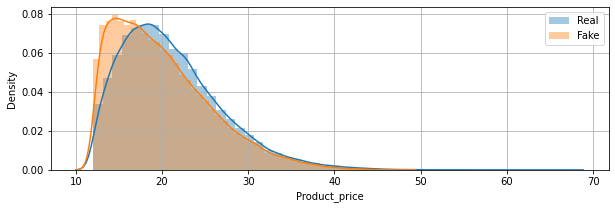

/home/ninja/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ninja/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


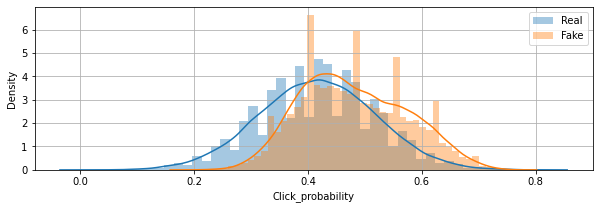

/home/ninja/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/ninja/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


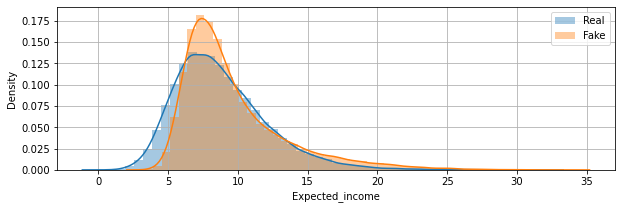

In [22]:
gan_summary(df_num, rho=rho)

## Intervenção

Fake total expected income: 661517.94
       Product_price  Click_probability  Expected_income
mean      25.143345           0.528666        13.230359
std        6.581292           0.055021         3.532970
25%       19.809999           0.500000        10.462200
50%       25.110001           0.530000        13.120000
75%       30.370001           0.570000        15.802575
Real total expected income: 439413.67
       Product_price  Click_probability  Expected_income
mean      21.093944           0.416619         8.788273
std        5.840870           0.103044         3.325084
25%       16.730000           0.350000         6.426200
50%       20.120000           0.420000         8.269050
75%       24.380000           0.490000        10.598400


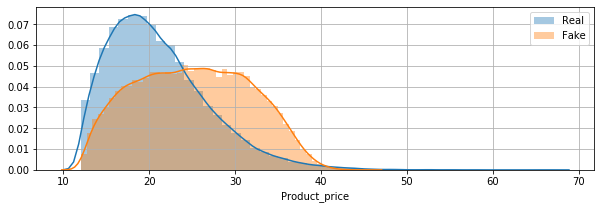

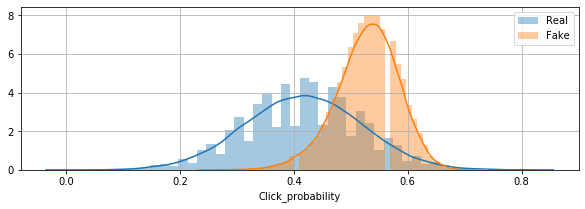

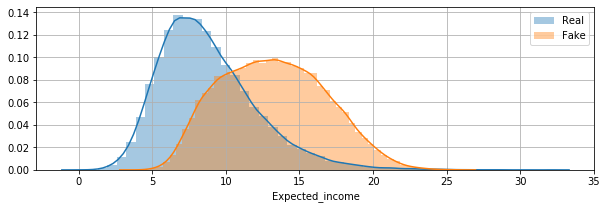

In [21]:
gan_summary(df_num, rho=1)

Fake total expected income: 402884.69
       Product_price  Click_probability  Expected_income
mean      21.181580           0.381306         8.057693
std        5.617642           0.079864         2.776473
25%       16.889999           0.330000         6.255200
50%       20.139999           0.370000         7.592000
75%       24.370001           0.430000         9.207925
Real total expected income: 439413.67
       Product_price  Click_probability  Expected_income
mean      21.093944           0.416619         8.788273
std        5.840870           0.103044         3.325084
25%       16.730000           0.350000         6.426200
50%       20.120000           0.420000         8.269050
75%       24.380000           0.490000        10.598400


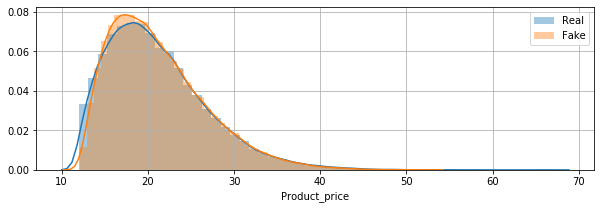

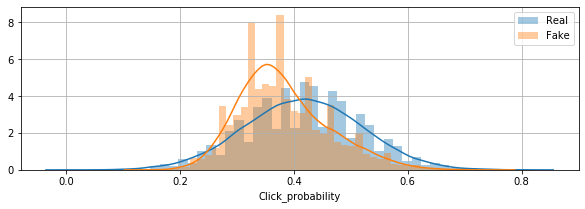

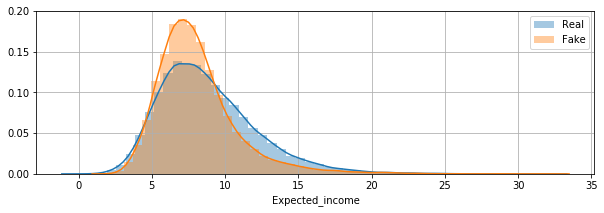

In [32]:
gan_summary(df_num, rho=0.1)

In [23]:
from ipywidgets import interactive
%matplotlib inline

In [27]:
def gan_summary_(rho):
    oh = np.eye(2)
    batch = X_tc.shape[0]
    l_s = np.random.choice([0,1],p=[1-rho,rho],size=(batch))
    l_s_ = torch.Tensor(oh[l_s]).type(torch.FloatTensor).cuda()
    l_s = torch.Tensor(l_s).type(torch.FloatTensor).reshape(batch,1).cuda()

    z = noise(batch, Z_dim).cuda()
    w = noise_uniform(batch, W_dim).cuda()
    g = G(z,w,l_s_)
    g = torch.Tensor(scaler.inverse_transform(g.cpu().data.numpy())).type(torch.FloatTensor).cuda()
    x_gen = torch.cat((g[:,0:5],l_s,g[:,5:]),dim=1)

    df_g = pd.DataFrame(data=x_gen.cpu().data.numpy(),columns=df_num.columns)

    df_g['Click_probability'] = np.round(df_g['Click_probability'].values,2)
    df_g['Image_quality'] = np.round(df_g['Image_quality'].values,0)
    df_g['Number_of_images'] = np.round(df_g['Number_of_images'].values,0)
    df_g['Product_price'] = np.round(df_g['Product_price'].values,2)
    
    df_g['Expected_income'] = df_g['Product_price'] * df_g['Click_probability']
    df_num['Expected_income'] = df_num['Product_price'] * df_num['Click_probability']

    plt.figure(figsize=(15,5))
    plt.subplot(221)
    sns.histplot(df_num['Product_price'],label='Real')
    sns.histplot(df_g['Product_price'],label='Fake')
    plt.xlim(0,60)
    plt.ylim(0,0.08)
    plt.legend(loc=0)
    plt.grid(True)
    plt.subplot(222)
    sns.histplot(df_num['Click_probability'],label='Real')
    sns.histplot(df_g['Click_probability'],label='Fake')
    plt.xlim(0,1)
    plt.ylim(0,11)
    plt.legend(loc=0)
    plt.grid(True)
    plt.subplot(223)
    sns.histplot(df_num['Expected_income'],label='Real')
    sns.histplot(df_g['Expected_income'],label='Fake') 
    plt.xlim(0,60)
    plt.ylim(0,0.20)
    plt.legend(loc=0)
    plt.grid(True)
    plt.show()
    
    df_g.drop('Expected_income',axis=1,inplace=True)
    df_num.drop('Expected_income',axis=1,inplace=True)

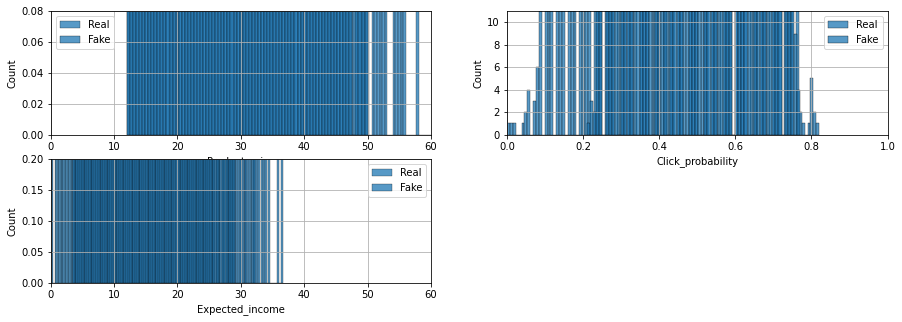

In [28]:
interactive_plot = interactive(gan_summary_,rho=(0.0,1.0,0.01))
interactive_plot.children[0].layout.width = '500px'
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot